In [1]:
import torch
from transformers import (Qwen2VLForConditionalGeneration, 
                          AutoTokenizer, 
                          AutoProcessor)
from PIL import Image, ImageDraw
import qwen_vl_utils 
from qwen_vl_utils import process_vision_info


In [2]:
import ast

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Loading model

In [4]:
model=Qwen2VLForConditionalGeneration.from_pretrained(
    "showlab/ShowUI-2B",
    torch_dtype=torch.bfloat16,
    device_map='auto'

).to(device)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


In [5]:
#Parameters
min_pixels=256*28*28
max_pixels=1344*28*28

In [6]:
processor=AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels
    )

In [57]:
def draw_point(img, point, radius):
    img=Image.open(img)
    x,y=point[0]*img.width, point[1]*img.height
    ImageDraw.Draw(img).ellipse((x-radius, y-radius, x+radius, y+radius), fill='red')
    return img

Prompt template

In [8]:
_SYSTEM = "Based on the screenshot of the page, I give a text description and you give its corresponding location. The coordinate represents a clickable location [x, y] for an element, which is a relative coordinate on the screenshot, scaled from 0 to 1."
def messages(img, query):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": _SYSTEM},
                {"type": "image", "image": img, "min_pixels": min_pixels, "max_pixels": max_pixels},
                {"type": "text", "text": query}
            ],
        }
    ]
    return messages

Data processing

In [9]:
def text_proces(mess):
    text=processor.apply_chat_template(
        mess,
        tokenize=False,
        add_generation_prompt=True,
    )
    return text

In [10]:
def input_process(img, query, nav=None):
    if nav:
        mess=messages_nav(img,query)
    else: 
        mess=messages(img, query)
    text=text_proces(mess)
    img_input, video_input=process_vision_info(mess)
    inputs=processor(
        text=[text],
        images=img_input,
        videos=video_input,
        padding=True,
        return_tensors='pt'
    ).to(device)
    return inputs

Generator

In [55]:
def generate(img, query, nav=None):
    inputs=input_process(img, query, nav)
    generated_ids=model.generate(**inputs,
                                 max_new_tokens=128
                                 )
    generated_ids_trimmed=[out_ids[len(in_ids):] for in_ids, 
                           out_ids in zip(inputs['input_ids'], 
                                          generated_ids)]
    output_text = processor.batch_decode(
        generated_ids_trimmed, 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=False
    )[0]
    if nav:
        print(output_text)
        xy=ast.literal_eval(output_text.split(':')[-1][:-1])
        #xy=ast.literal_eval(output_text['position'])
        img=draw_point(img, xy,10)
        display(img)
        return output_text
    else:
        xy=ast.literal_eval(output_text)
        img=draw_point(img, xy,10)
        return img

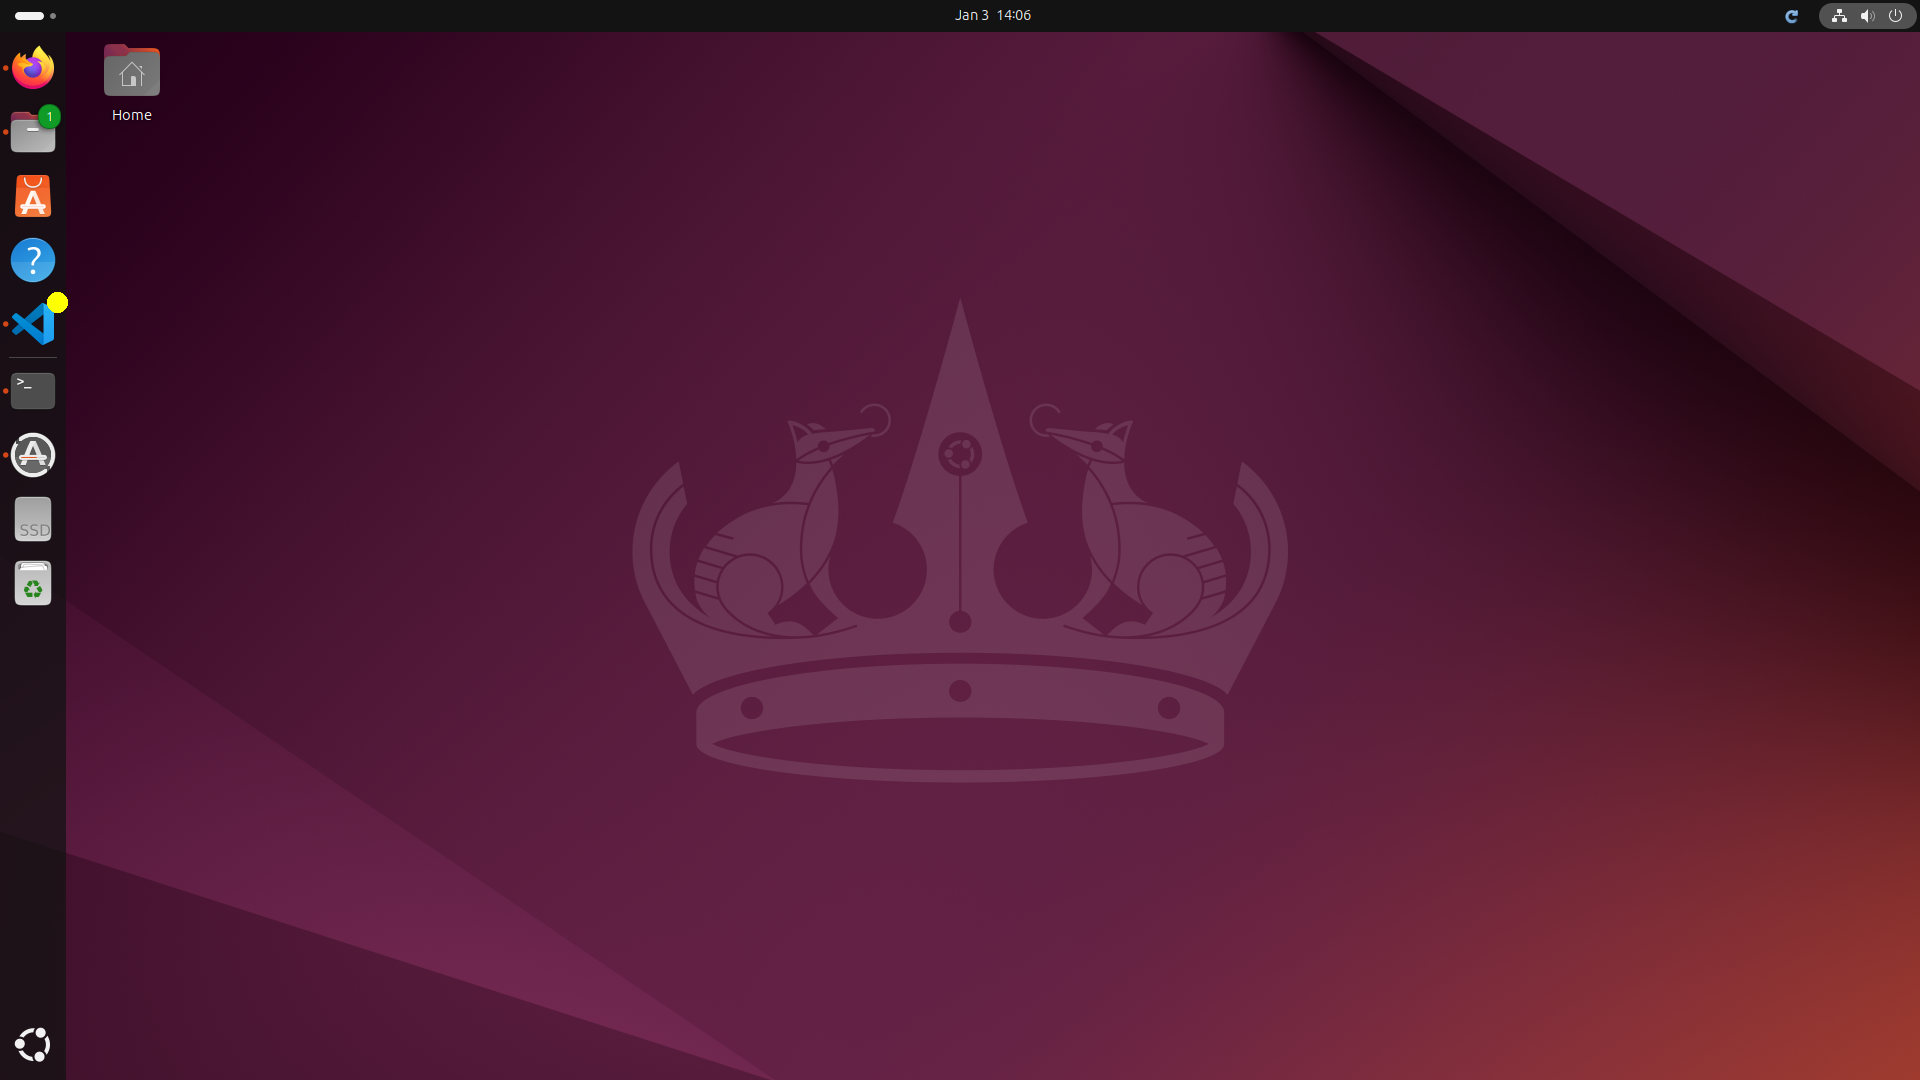

In [142]:
#Prompt
img='ScreenUbuntu.png'
query='programming'
generate(img, query)

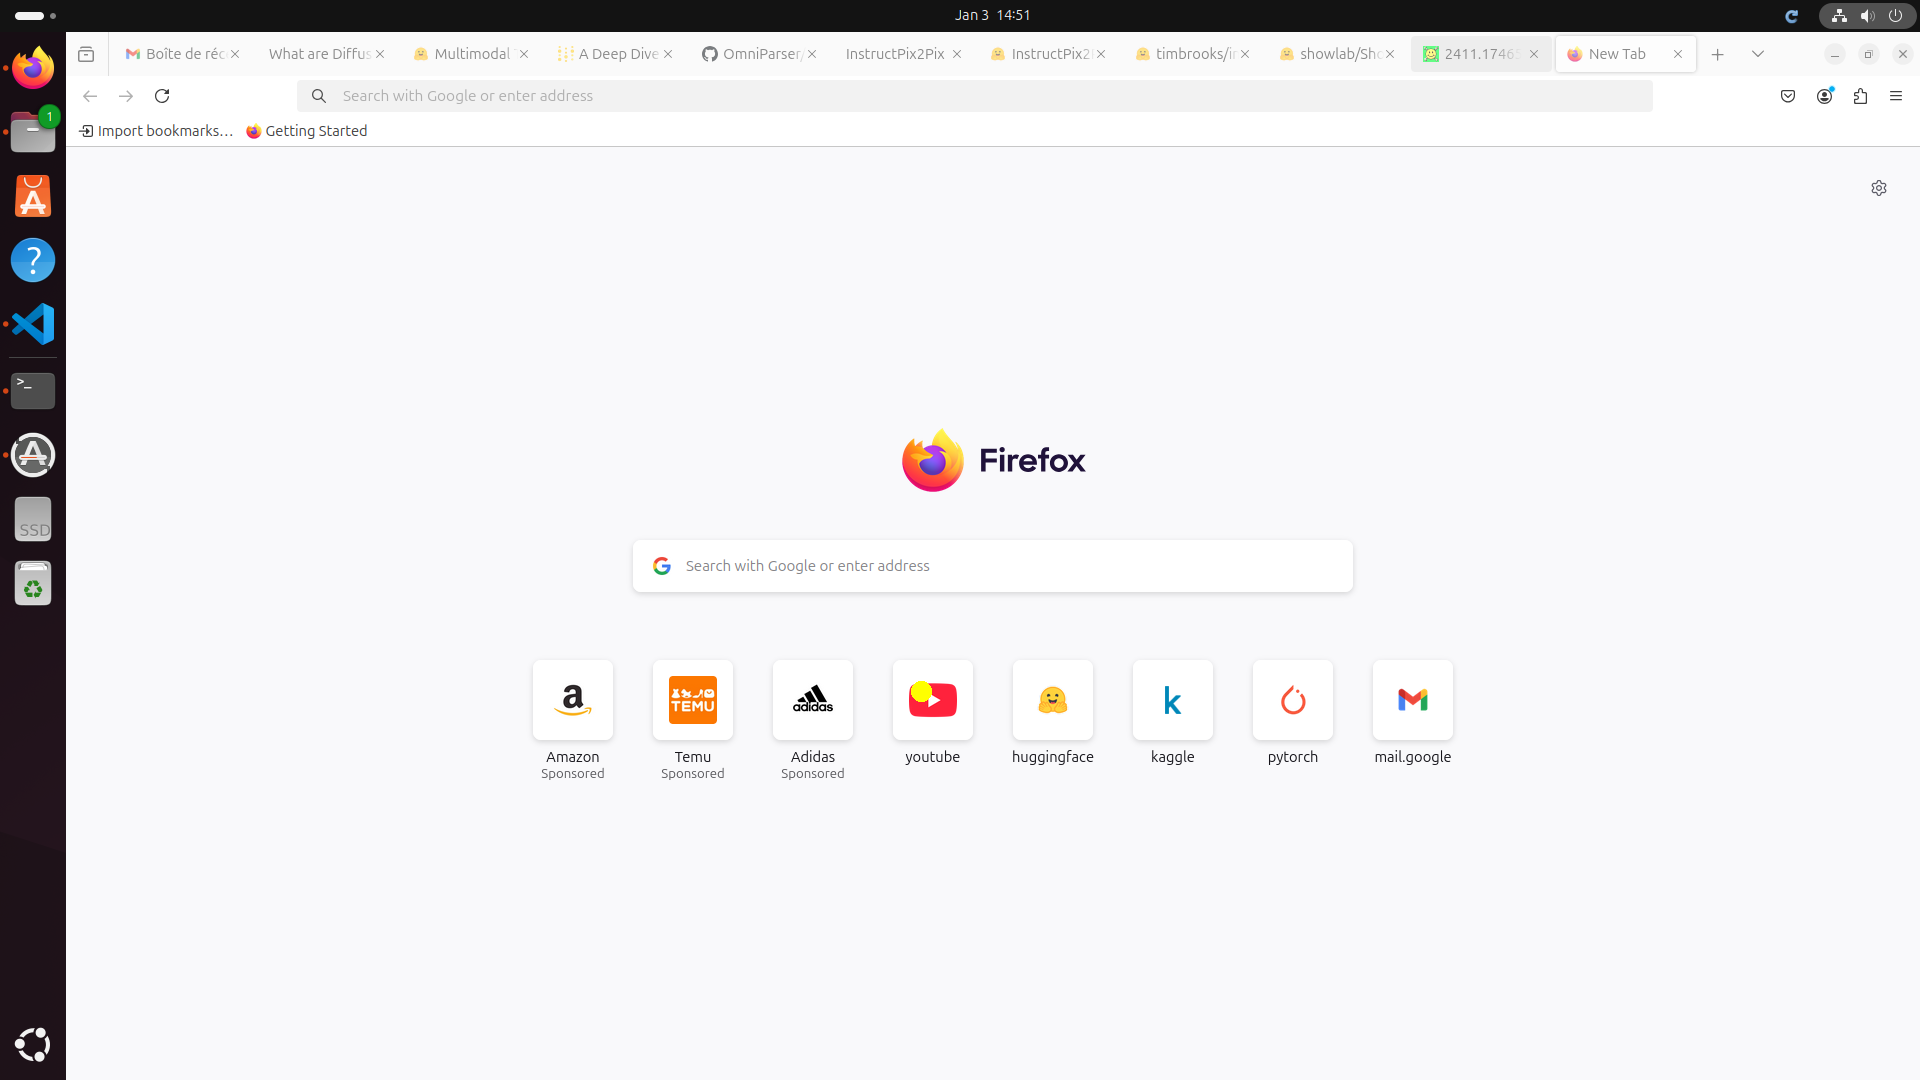

In [143]:
#Prompt
img='ScreenFire2.png'
query='Watch a video'
generate(img, query)

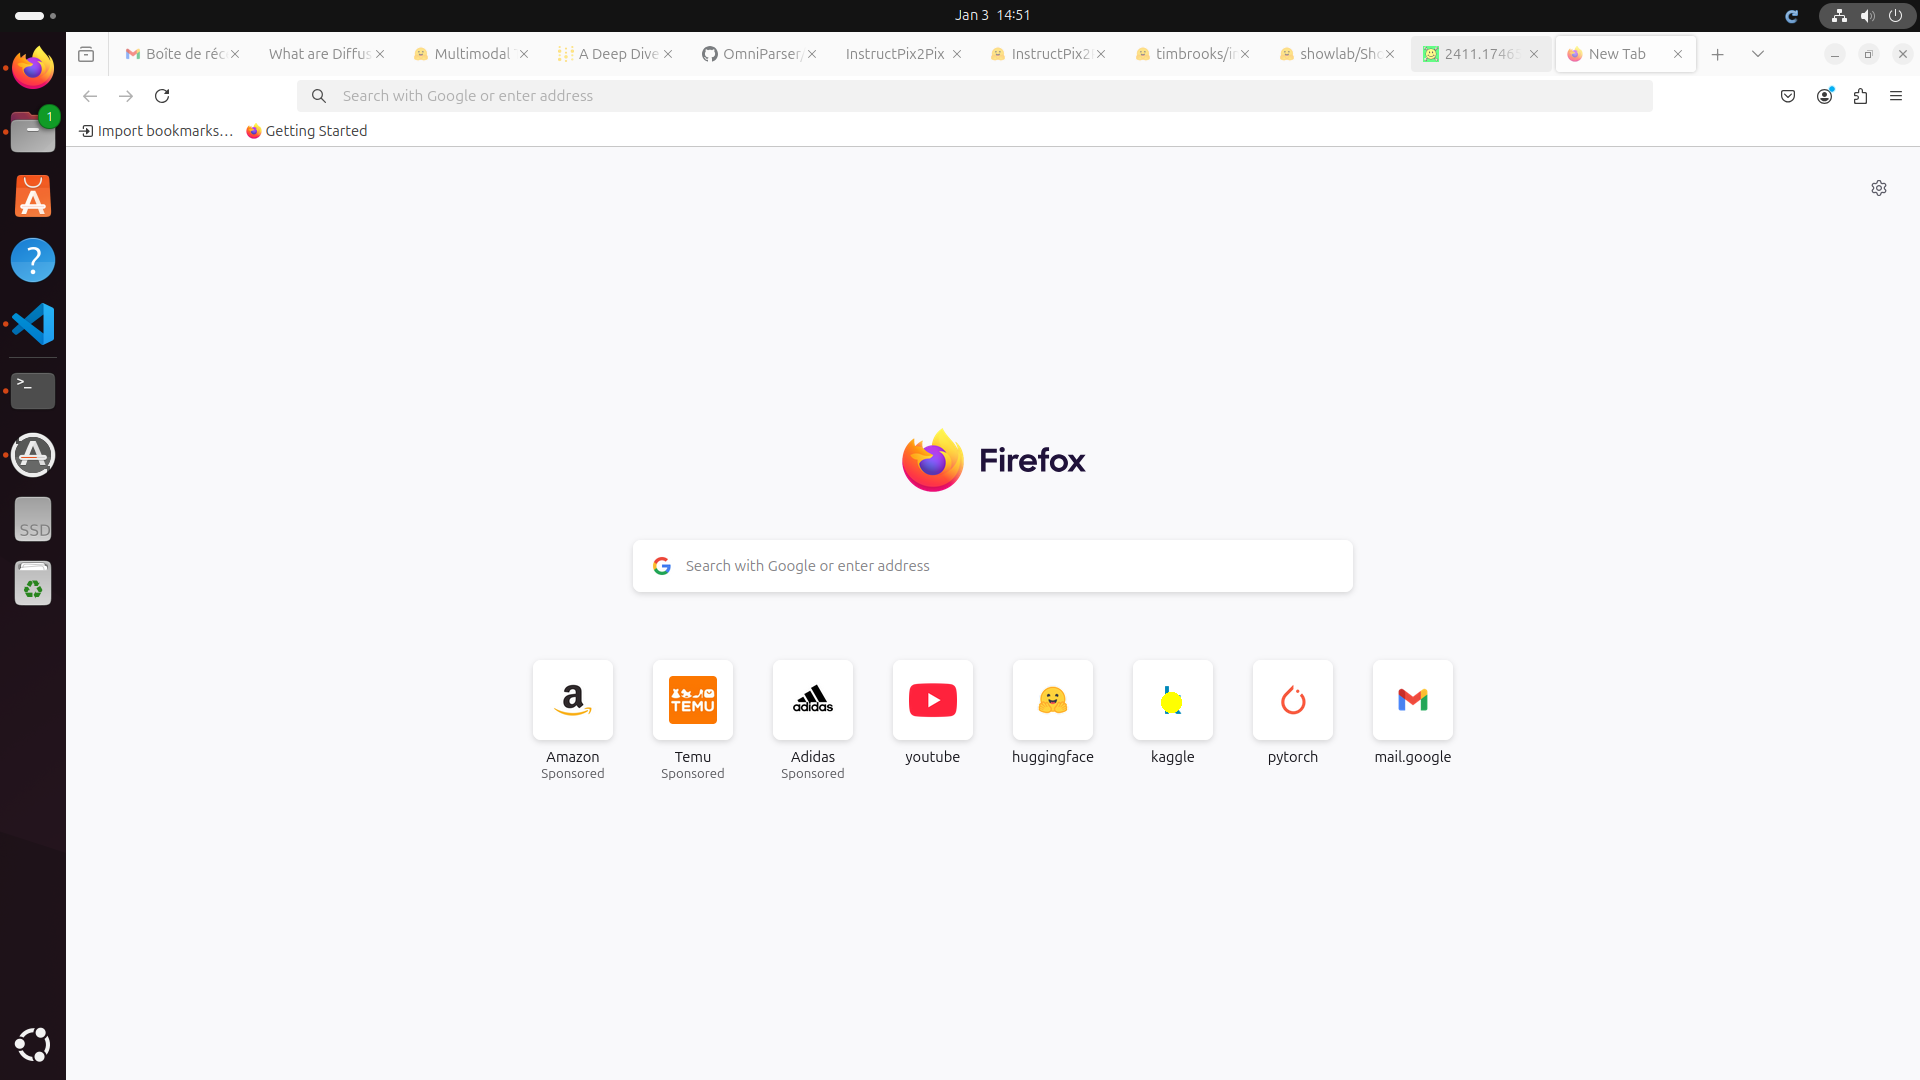

In [136]:
#Prompt
img='ScreenFire2.png'
query='open the kaggle web'
generate(img, query)

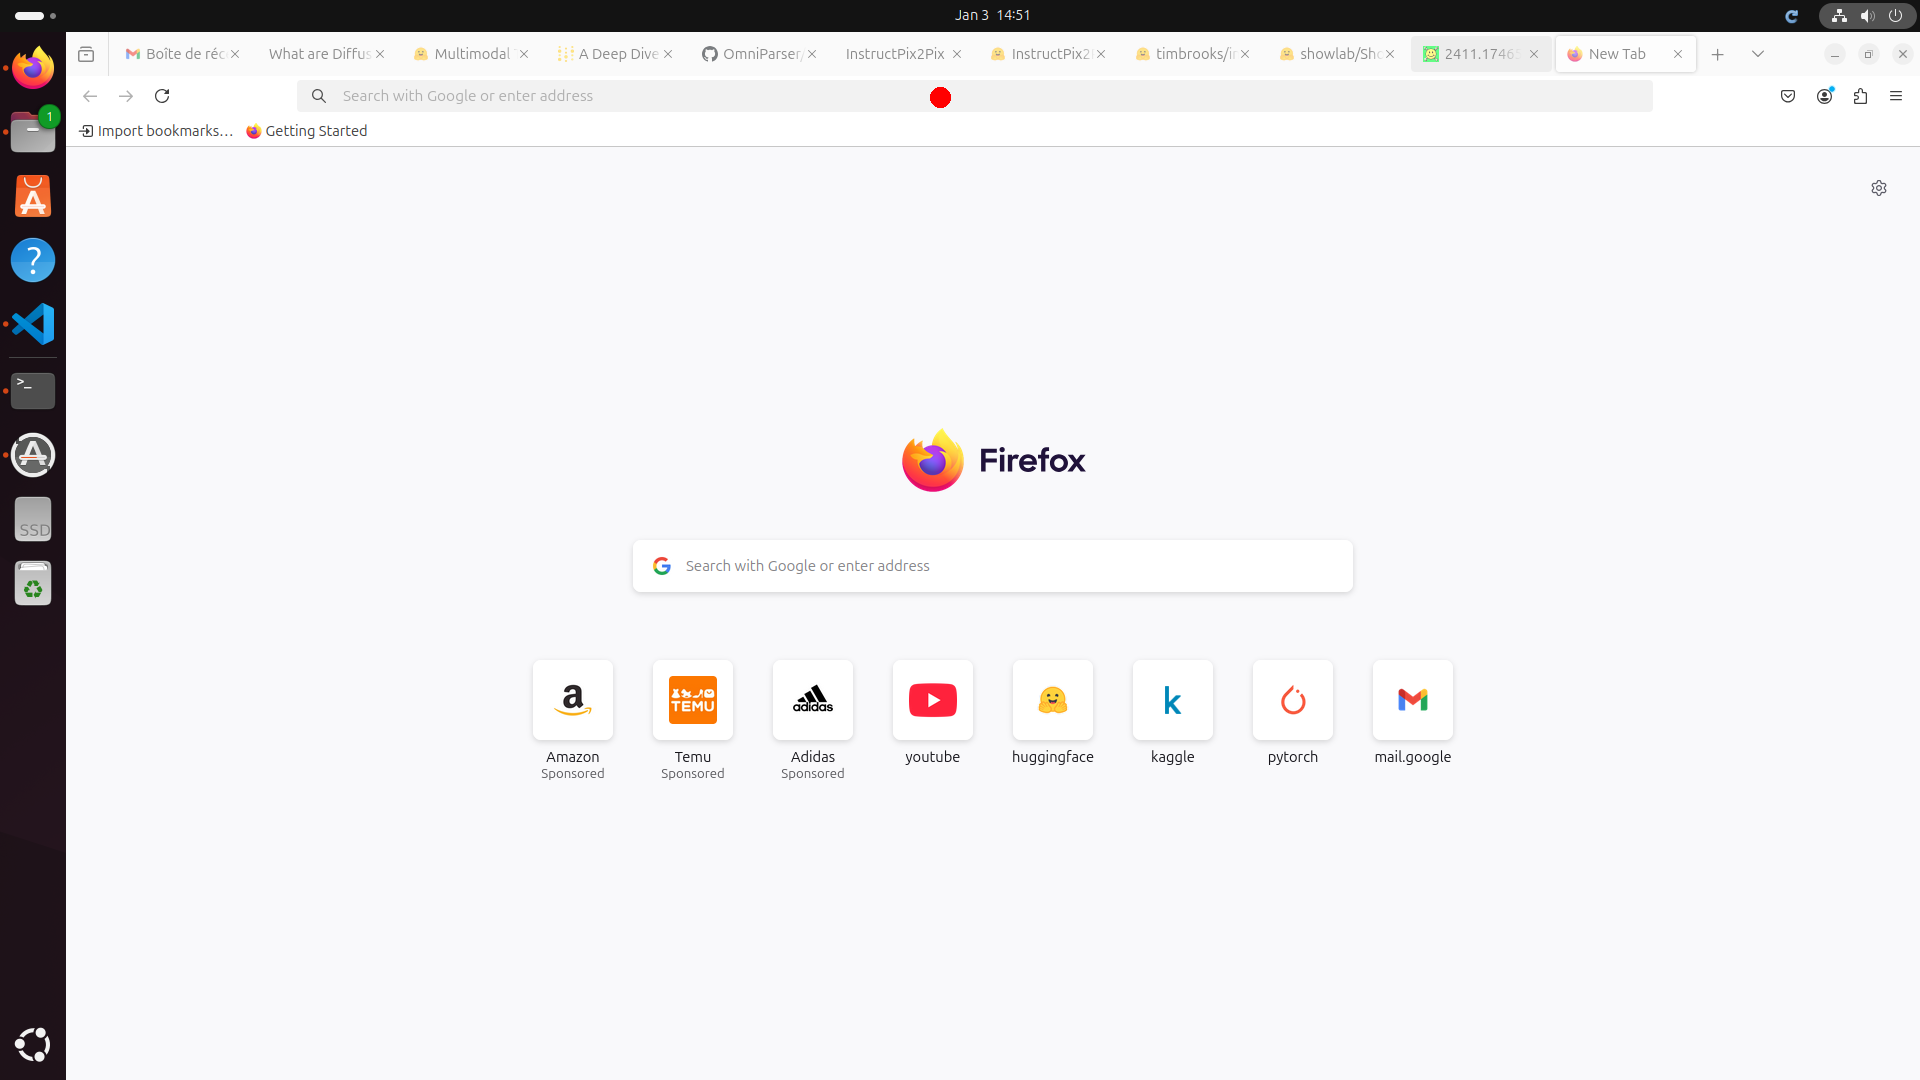

In [65]:
#Prompt
img='ScreenFire2.png'
query='find the best footballer of this year'
generate(img, query)

{'action': 'CLICK', 'value': None, 'position': [0.49, 0.52]}


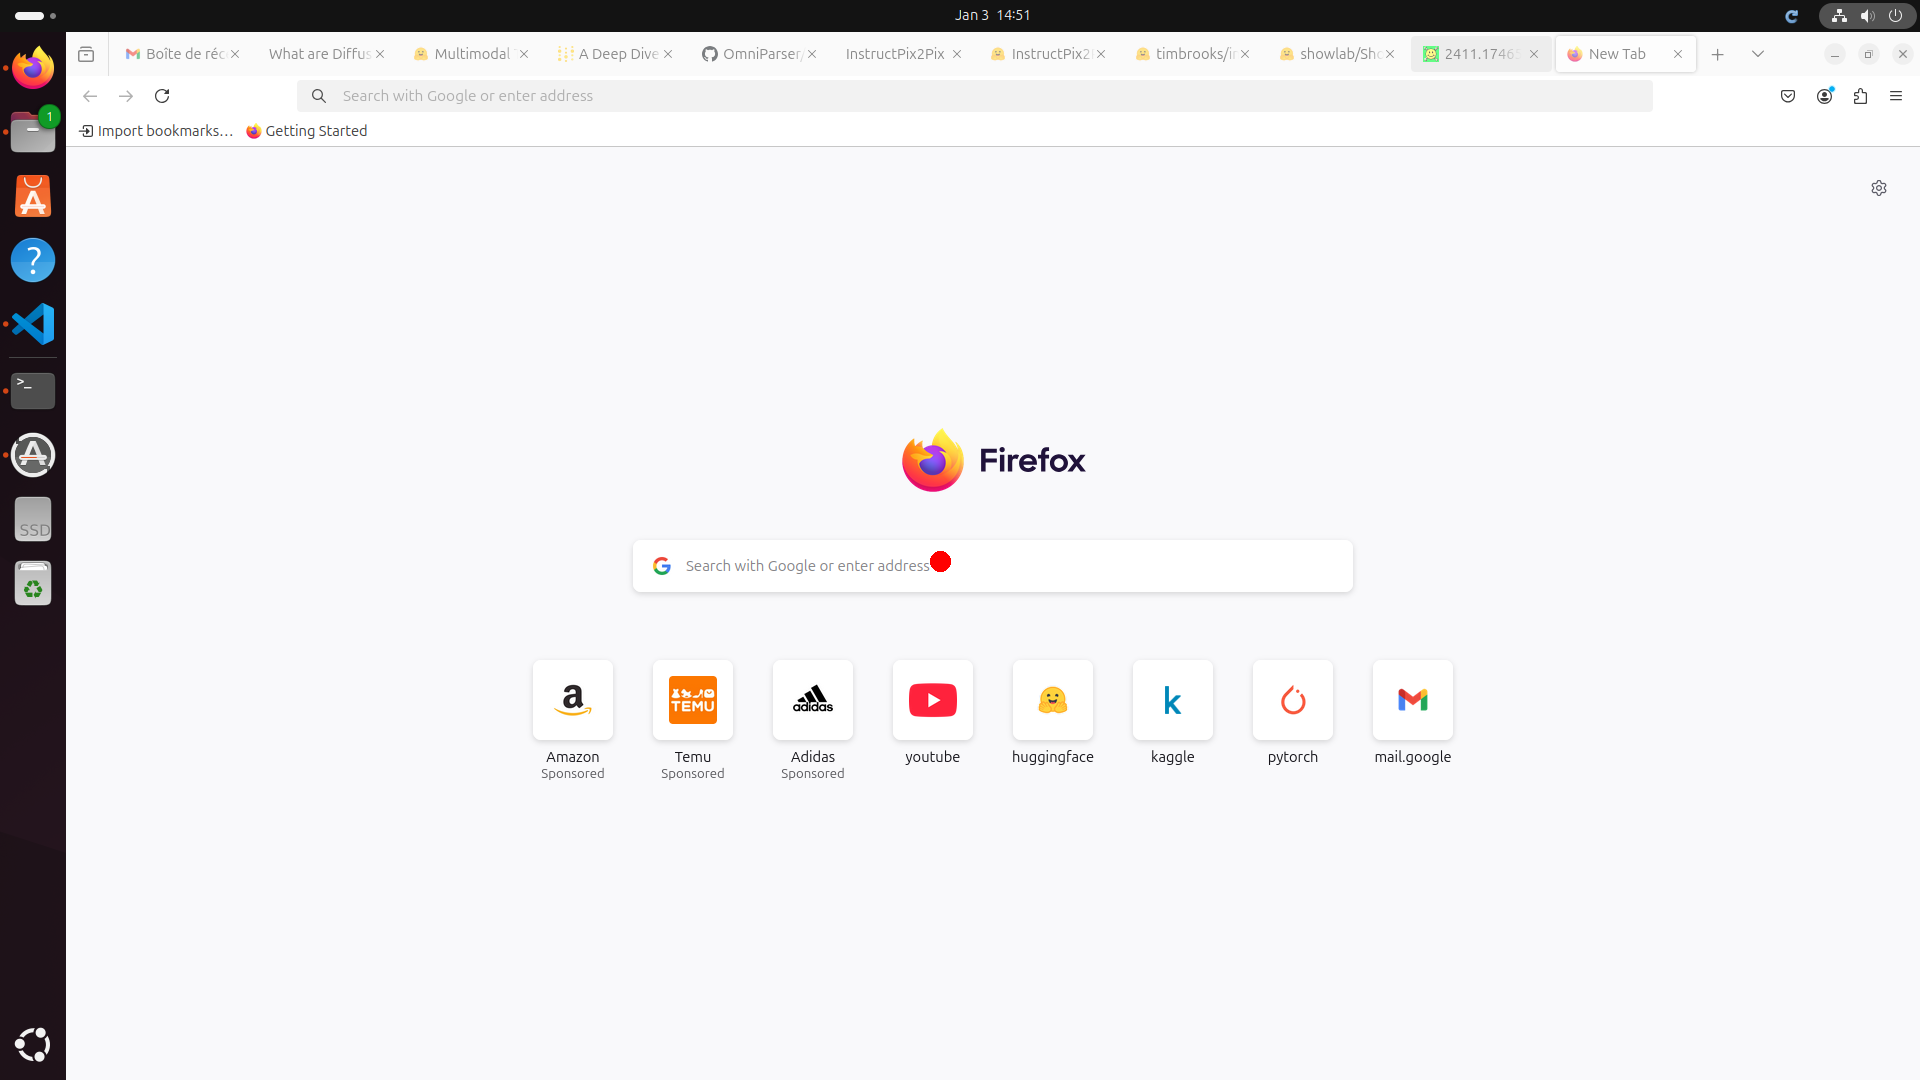

"{'action': 'CLICK', 'value': None, 'position': [0.49, 0.52]}"

In [63]:
#Prompt
img='ScreenFire2.png'
query='find the best footballer of this year'
generate(img, query, nav=True)

UI Navigation

Prompt template

In [14]:
_NAV_SYSTEM = """You are an assistant trained to navigate the {_APP} screen. 
Given a task instruction, a screen observation, and an action history sequence, 
output the next action and wait for the next observation. 
Here is the action space:
{_ACTION_SPACE}
"""

In [15]:
_NAV_FORMAT = """
Format the action as a dictionary with the following keys:
{'action': 'ACTION_TYPE', 'value': 'element', 'position': [x,y]}

If value or position is not applicable, set it as `None`.
Position might be [[x1,y1], [x2,y2]] if the action requires a start and end position.
Position represents the relative coordinates on the screenshot and should be scaled to a range of 0-1.
"""

In [16]:
action_map = {
'web': """
1. `CLICK`: Click on an element, value is not applicable and the position [x,y] is required. 
2. `INPUT`: Type a string into an element, value is a string to type and the position [x,y] is required. 
3. `SELECT`: Select a value for an element, value is not applicable and the position [x,y] is required. 
4. `HOVER`: Hover on an element, value is not applicable and the position [x,y] is required.
5. `ANSWER`: Answer the question, value is the answer and the position is not applicable.
6. `ENTER`: Enter operation, value and position are not applicable.
7. `SCROLL`: Scroll the screen, value is the direction to scroll and the position is not applicable.
8. `SELECT_TEXT`: Select some text content, value is not applicable and position [[x1,y1], [x2,y2]] is the start and end position of the select operation.
9. `COPY`: Copy the text, value is the text to copy and the position is not applicable.
""",

'phone': """
1. `INPUT`: Type a string into an element, value is not applicable and the position [x,y] is required. 
2. `SWIPE`: Swipe the screen, value is not applicable and the position [[x1,y1], [x2,y2]] is the start and end position of the swipe operation.
3. `TAP`: Tap on an element, value is not applicable and the position [x,y] is required.
4. `ANSWER`: Answer the question, value is the status (e.g., 'task complete') and the position is not applicable.
5. `ENTER`: Enter operation, value and position are not applicable.
"""
}

In [17]:
split='web'
system_prompt = _NAV_SYSTEM.format(_APP=split, _ACTION_SPACE=action_map[split])

In [18]:
def messages_nav(img, query):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": system_prompt},
                {"type": "text", "text": f'Task: {query}'},
                # {"type": "text", "text": PAST_ACTION},
                {"type": "image", "image": img, "min_pixels": min_pixels, "max_pixels": max_pixels},
            ],
        }
    ]
    return messages

{'action': 'CLICK', 'value': None, 'position': [0.49, 0.52]}


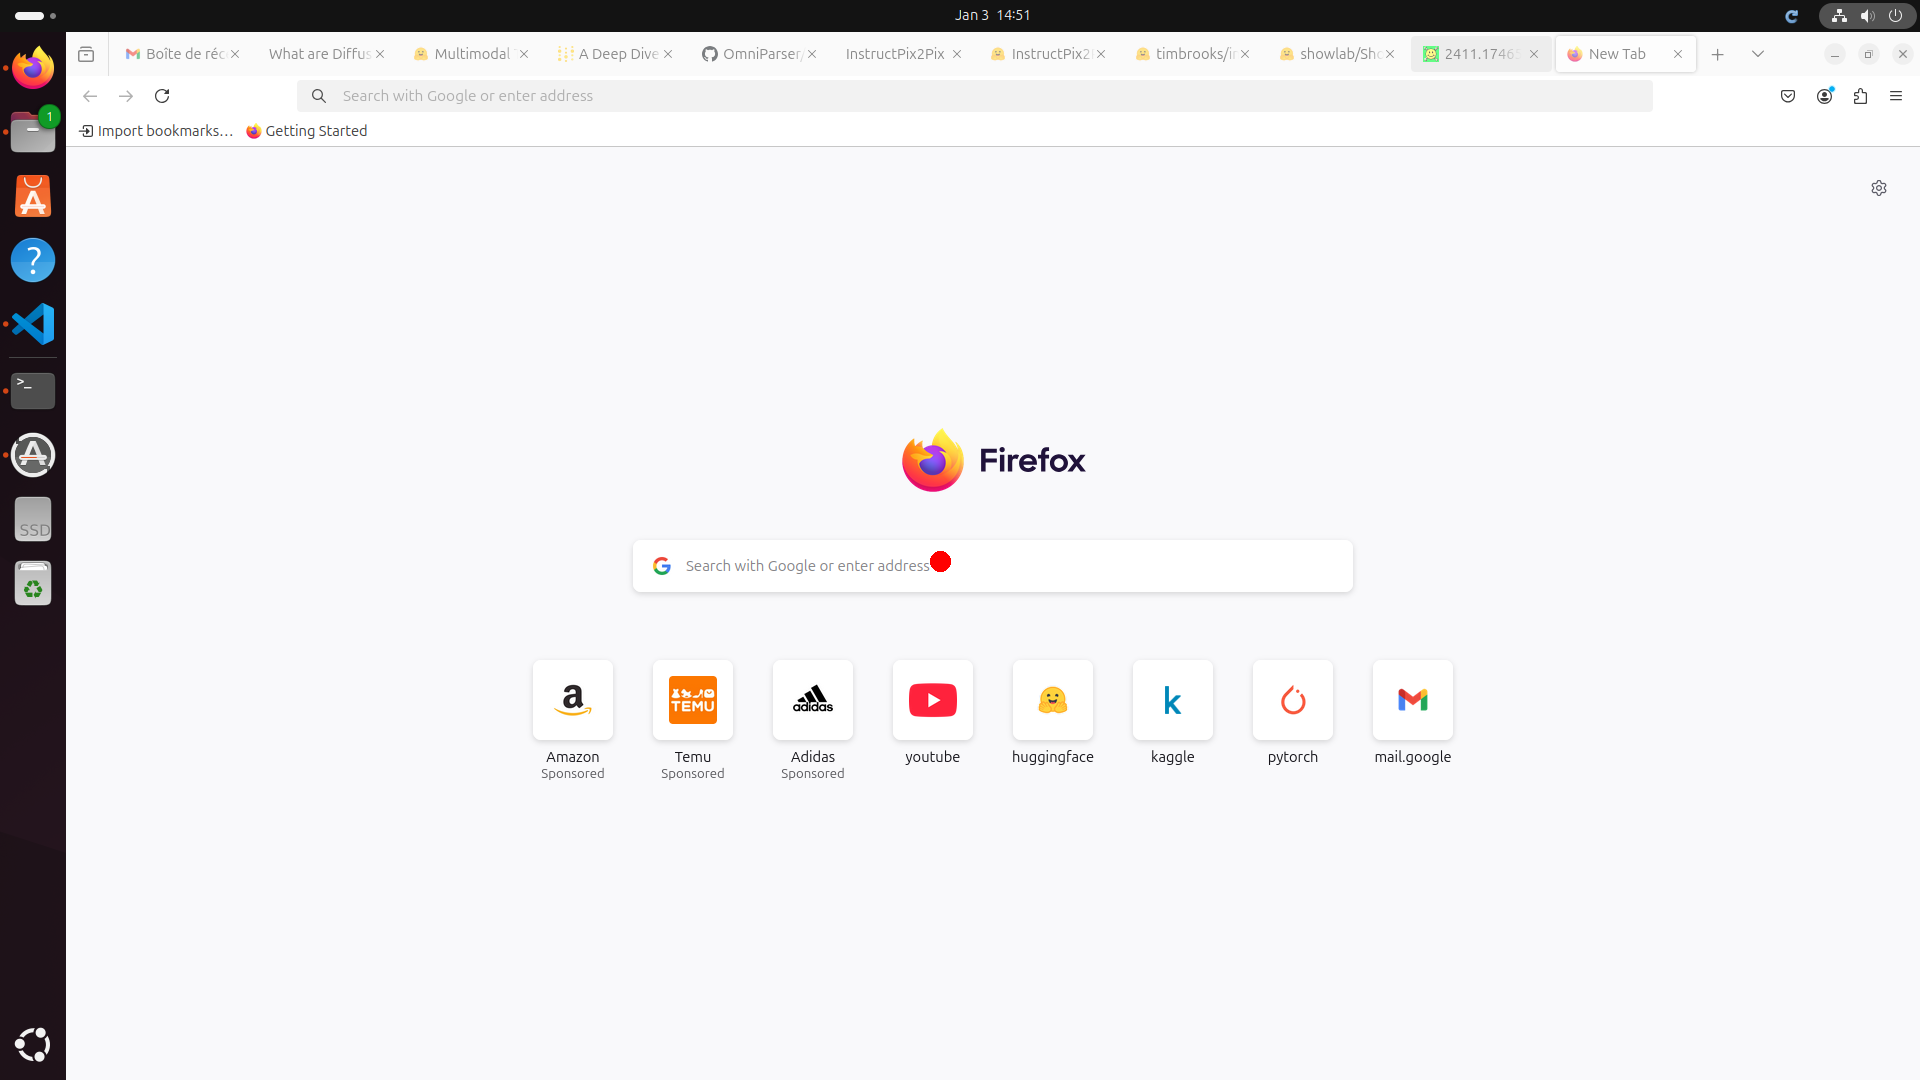

In [59]:
#Prompt
img='ScreenFire2.png'
query = "Search the weather for the Paris city."
out_put=generate(img, query, nav=True)